# Assignment 4: Deep Learning 

In this assignment, you are required to implement a deep learning pipeline on CIFAR dataset. The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes (50000/10000 for training/test)

Your grade will be given according to how far you can achieve the following requirements:
- Task 1: Implement a running CNN pipeline. Your NN consists of at least one CNN layer and one linear layer. (50%)
    - Hint: CIFAR contains RGB-color images, which have three channels. 
- Task 2: Within 20 epochs, your CNN model achieves at least 60% accuracy on testing dataset. (30%)
    - Hint: if you feel the training time is long, think about using Google Colab
- Task 3: Within 20 epochs, the higher accuracy you have, the more points you will receive (like a data science competition). Enjoy! (20%)


In [1]:
# load necessary libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torchvision import transforms
import matplotlib.pyplot as plt
from time import time
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [2]:
# download CIFAR10 dataset
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomAdjustSharpness(2),
            transforms.ToTensor()
          ]) # ToTensor() transforms the data to tensor type and rescale [0,255] uint8 to [0,1] float
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# print(dir(training_data)) # print all attribute of an object
# print(training_data.targets) # print info of the first picture
# plt.imshow(training_data.data[0,:], cmap=plt.get_cmap('gray')) # visualize the first picture

Files already downloaded and verified
Files already downloaded and verified


### Step 1: Prepare Data

Shape of X [N, C, H, W]:  torch.Size([128, 3, 32, 32]) torch.float32
Shape of y:  torch.Size([128]) torch.int64
torch.Size([10, 32, 32, 3])


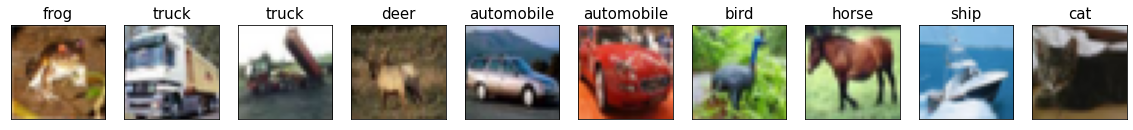

In [3]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# check the first batch of the dataset
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape, X.dtype) # 
    print("Shape of y: ", y.shape, y.dtype)
    break
    
# N: number of data instance in a batch
# C: channel, number of colors in a pixel here
# [H, W]: Height and width of a picture
    
nsamples = 10
imgs = training_data.data[0:nsamples,:]
# imgs = np.expand_dims(imgs)
imgs = torch.tensor(imgs)
imgs = imgs/255
print(imgs.shape)
labels = training_data.targets[0:nsamples]
classes_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]


fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, :, :, :], cmap=plt.get_cmap('gray'))
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Step 2: Define CNN

In [4]:
# your code below
# please use GPU. I use Google Colar.
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn_stack = nn.Sequential(          
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2,2), #16*16*64
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2,2), #8*8*128
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout(0.2), nn.MaxPool2d(2,2), #4*4*256=4096
            nn.Conv2d(256,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(),

            nn.Flatten(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 10)
        )    
        
    def forward(self, x):
        logits = self.cnn_stack(x)
        return logits

model = MyModel().to(device)
print(model)







MyModel(
  (cnn_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(

### Step 3: Define loss function and the optimizer

In [5]:
# your code below
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())






### Step 4: Train the neural nets

In [6]:
# your code below
# please use GPU
epochs=20

for i in range(epochs): # iterate over epochs
    tic = time()
    model.train()
    train_loss=0
    for j, (X, y) in enumerate(train_dataloader): # iterate over batches
        X, y = X.to(device), y.to(device) 
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print learning process every 100 batches
        if j % 100 == 0:
            loss, current = loss.item(), j * len(X)
            print(f"epoch {i} batch {j} loss: {loss/batch_size:>7f}")
    
    train_time = time() - tic
    
    # print test results after every epochs    
    with torch.no_grad():
        model.eval()
        test_loss=0
        hit=0
        for (X, y) in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            hit += (pred.argmax(1) == y).sum().item()
        print(f"epoch {i} training time: {train_time:>3f}s, train loss: {train_loss/len(train_dataloader.dataset):>7f} test loss: {test_loss/len(test_dataloader.dataset):>7f} accuracy: {hit/len(test_dataloader.dataset) :>7f}")    








epoch 0 batch 0 loss: 0.017990
epoch 0 batch 100 loss: 0.012264
epoch 0 batch 200 loss: 0.009165
epoch 0 batch 300 loss: 0.008726
epoch 0 training time: 42.595431s, train loss: 0.011200 test loss: 0.008928 accuracy: 0.612400
epoch 1 batch 0 loss: 0.008773
epoch 1 batch 100 loss: 0.007076
epoch 1 batch 200 loss: 0.007354
epoch 1 batch 300 loss: 0.006019
epoch 1 training time: 41.243056s, train loss: 0.007372 test loss: 0.008658 accuracy: 0.627200
epoch 2 batch 0 loss: 0.005514
epoch 2 batch 100 loss: 0.005822
epoch 2 batch 200 loss: 0.006700
epoch 2 batch 300 loss: 0.005514
epoch 2 training time: 40.850532s, train loss: 0.005960 test loss: 0.005708 accuracy: 0.762200
epoch 3 batch 0 loss: 0.005616
epoch 3 batch 100 loss: 0.004846
epoch 3 batch 200 loss: 0.005462
epoch 3 batch 300 loss: 0.004805
epoch 3 training time: 40.841233s, train loss: 0.005131 test loss: 0.005191 accuracy: 0.780200
epoch 4 batch 0 loss: 0.003072
epoch 4 batch 100 loss: 0.004054
epoch 4 batch 200 loss: 0.003574
epo